# Catching Hackers
For this chapter, we will be simulating the data we will work with using the [`login_attempt_simulator` package](https://github.com/stefmolin/login-attempt-simulator). The simulator needs to generate random numbers from various distributions. Here is an example of each of them:

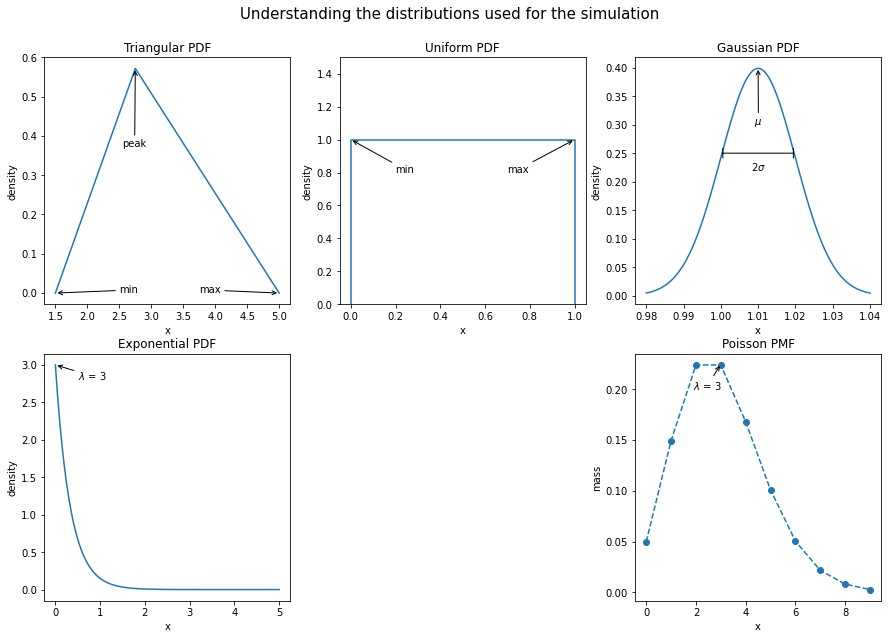

In [2]:
%matplotlib inline
from visual_aids import sim_viz

_ = sim_viz.show_distributions()

*Note: the Poisson distribution is discrete while the others are continuous. We use the Poisson distribution to model arrivals (users coming to login for this example). Discrete distributions have PMFs (probability mass functions) instead of PDFs.*

The `simulate.py` script can be run from the command line to run the simulation:

In [3]:
!python3 simulate.py -h

We will simulate November 2018 using a seed of 0 and making the user base:

In [5]:
!python3 simulate.py -ms 0 30 "2018-11-01"

## Setup

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

log = pd.read_csv('logs/log.csv', index_col='datetime', parse_dates=True)
attacks = pd.read_csv(
    'logs/attacks.csv',
    converters={'start': np.datetime64, 'end': np.datetime64}
) # make start and end columns datetimes but not the index

## Understanding the Data
The login attempts recorded from the website look like this:

In [7]:
log.head()

,source_ip,username,success,failure_reason
datetime,,,,
2018-11-01 00:36:52.617978,142.89.86.32,vkim,True,NaN
2018-11-01 01:00:23.166623,5.118.187.36,kkim,True,NaN
2018-11-01 01:31:50.779608,142.89.86.32,vkim,False,error_wrong_password
2018-11-01 01:31:51.779608,142.89.86.32,vkim,True,NaN
2018-11-01 01:32:44.016230,15.176.178.91,kkim,True,NaN


The labeled data we have to research how to detect the attackers looks like this:

In [8]:
attacks.head()

,start,end,source_ip
0,2018-11-02 05:06:17.152636,2018-11-02 05:10:30.152636,212.79.15.228
1,2018-11-02 11:42:38.771415,2018-11-02 11:45:58.771415,44.207.171.119
2,2018-11-03 17:49:39.023954,2018-11-03 17:52:27.023954,15.223.158.165
3,2018-11-03 19:45:05.820292,2018-11-03 19:49:11.820292,68.102.121.161
4,2018-11-04 02:51:07.163402,2018-11-04 02:52:09.163402,103.93.254.233


We can use `shape` to see the number of attacks and login attempts:

In [9]:
attacks.shape, log.shape

((72, 3), (12836, 4))

What percentage of IP addresses were from attackers?

In [10]:
attacks.source_ip.nunique() / log.source_ip.nunique()

0.22018348623853212

## EDA
Can we find suspicious activity looking at hourly attempts to log in?

[Text(0.5, 0, 'datetime'), Text(0, 0.5, 'attempts')]

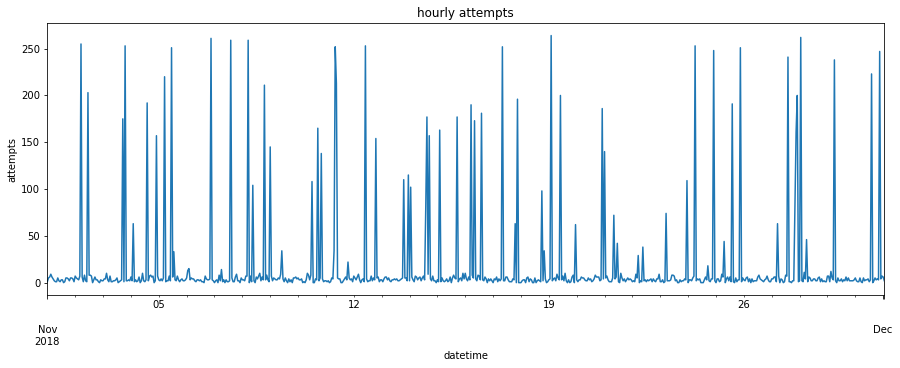

In [11]:
# attempts over time
log.assign(attempts=1).attempts.resample('1H').sum()\
    .plot(figsize=(15, 5), title='hourly attempts')\
    .set(xlabel='datetime', ylabel='attempts')

How many attempts came from each IP address?

In [12]:
log.source_ip.value_counts().describe()

count    327.000000
mean      39.253823
std       69.279330
min        1.000000
25%        5.000000
50%       10.000000
75%       22.500000
max      257.000000
Name: source_ip, dtype: float64

What does the distribution of attempts per IP address look like?

Text(0.5, 0.98, 'Attempts per IP Address')

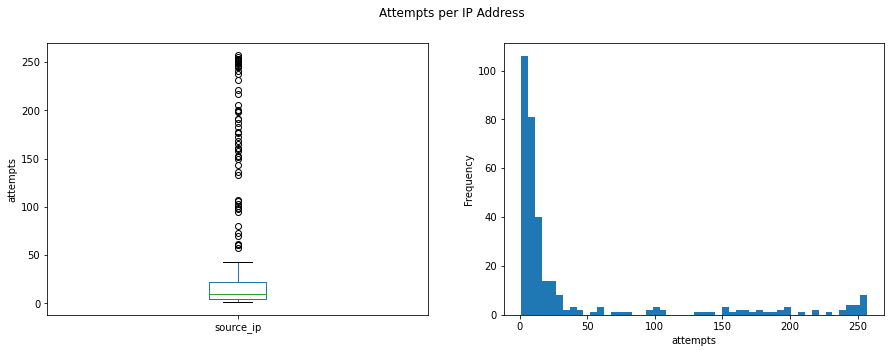

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
log.source_ip.value_counts().plot(kind='box', ax=axes[0]).set_ylabel('attempts')
log.source_ip.value_counts().plot(kind='hist', bins=50, ax=axes[1]).set_xlabel('attempts')
fig.suptitle('Attempts per IP Address')

What percent of the top IP addresses are hackers?

In [14]:
num_hackers = attacks.source_ip.nunique()
log.source_ip.value_counts().index[:num_hackers]\
    .isin(attacks.source_ip).sum() / num_hackers

0.8888888888888888

What does the average hourly attempts per IP address look like over the time period?

Text(0, 0.5, 'average hourly attempts per IP address')

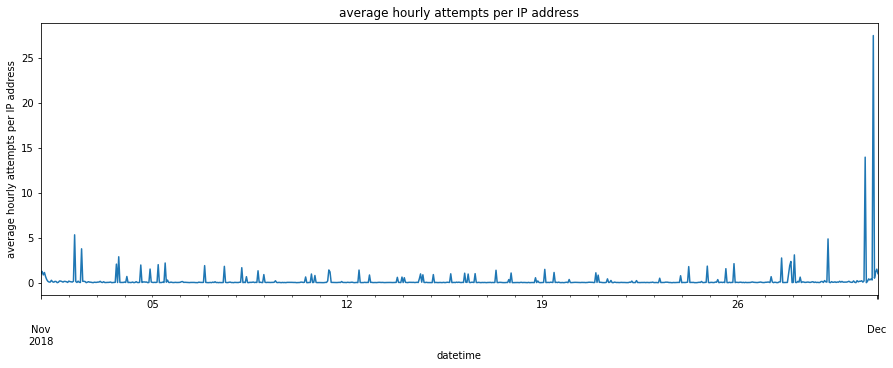

In [15]:
# attempts per ip address
log.assign(attempts=1).groupby('source_ip').attempts\
    .resample('1H').sum().unstack().mean()\
    .plot(figsize=(15, 5), title='average hourly attempts per IP address')\
    .set_ylabel('average hourly attempts per IP address')

What percentage of the time was a hacker's attempt successful?

In [16]:
log[log.source_ip.isin(attacks.source_ip)]\
    .success.value_counts(normalize=True)

False    0.831801
True     0.168199
Name: success, dtype: float64

What percentage of the time are valid users' attempts successful?

In [17]:
log[~log.source_ip.isin(attacks.source_ip)]\
    .success.value_counts(normalize=True)

True     0.873957
False    0.126043
Name: success, dtype: float64

Why is each group failing?

In [18]:
pd.crosstab(
    index=pd.Series(
        log.source_ip.isin(attacks.source_ip), name='is_hacker'
    ), columns=log.failure_reason
)

failure_reason,error_account_locked,error_wrong_password,error_wrong_username
is_hacker,,,
False,1,299,2
True,0,3316,5368


How many times does a user try to log in per hour? Valid users don't make many mistakes with their credentials, so if the hackers make many attempts with many users, we flag it.

Text(0, 0.5, 'average hourly attempts per user')

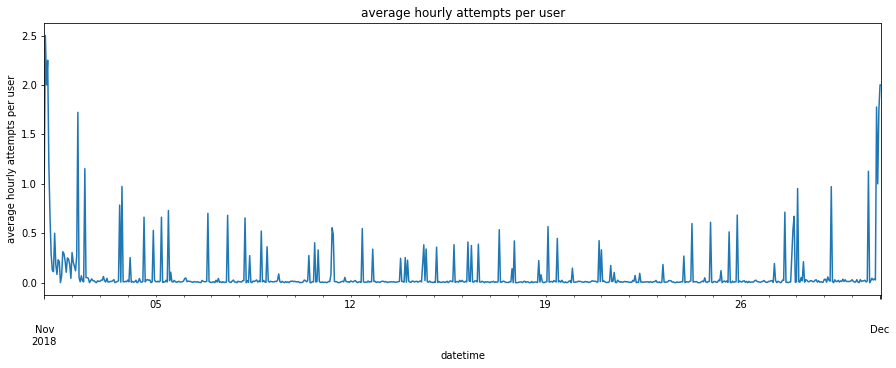

In [19]:
# attempts per user
log.assign(attempts=1).groupby('username').attempts\
    .resample('1H').sum().unstack().mean()\
    .plot(figsize=(15, 5), title='average hourly attempts per user')\
    .set_ylabel('average hourly attempts per user')

Calculate metrics per IP address

In [20]:
pivot = log.pivot_table(
    values='success', index=log.source_ip, 
    columns=log.failure_reason.fillna('success'), 
    aggfunc='count', fill_value=0
)
pivot.insert(0, 'attempts', pivot.sum(axis=1))
pivot = pivot.sort_values('attempts', ascending=False).assign(
    success_rate=lambda x: x.success / x.attempts,
    error_rate=lambda x: 1 - x.success_rate
)
pivot.head()

failure_reason,attempts,error_account_locked,error_wrong_password,error_wrong_username,success,success_rate,error_rate
source_ip,,,,,,,
85.1.221.89,257,0,92,128,37,0.143969,0.856031
109.67.154.113,255,0,78,144,33,0.129412,0.870588
212.79.15.228,253,0,89,127,37,0.146245,0.853755
181.217.195.170,253,0,70,138,45,0.177866,0.822134
211.56.212.113,253,0,88,120,45,0.177866,0.822134


Most successful IP addresses:

In [21]:
pivot.sort_values('success_rate', ascending=False).head()

failure_reason,attempts,error_account_locked,error_wrong_password,error_wrong_username,success,success_rate,error_rate
source_ip,,,,,,,
81.99.181.254,1,0,0,0,1,1.0,0.0
101.154.143.93,19,0,0,0,19,1.0,0.0
41.77.180.210,6,0,0,0,6,1.0,0.0
134.14.49.41,6,0,0,0,6,1.0,0.0
123.148.94.96,5,0,0,0,5,1.0,0.0


What looks out of place with the five-number summary?

In [22]:
pivot.describe()

failure_reason,attempts,error_account_locked,error_wrong_password,error_wrong_username,success,success_rate,error_rate
count,327.000000,327.000000,327.000000,327.000000,327.000000,327.000000,327.000000
mean,39.253823,0.003058,11.055046,16.422018,11.773700,0.732863,0.267137
std,69.279330,0.055300,22.851280,37.282941,10.995712,0.314405,0.314405
min,1.000000,0.000000,0.000000,0.000000,1.000000,0.098361,0.000000
25%,5.000000,0.000000,0.000000,0.000000,4.000000,0.666667,0.000000
50%,10.000000,0.000000,1.000000,0.000000,7.000000,0.857143,0.142857
75%,22.500000,0.000000,4.000000,0.000000,15.000000,1.000000,0.333333
max,257.000000,1.000000,92.000000,148.000000,53.000000,1.000000,0.901639


Are there IP addresses being used with many distinct usernames?

In [23]:
log.groupby('source_ip').agg(dict(username='nunique'))\
    .username.value_counts().describe()

count     53.000000
mean       6.169811
std       34.562505
min        1.000000
25%        1.000000
50%        1.000000
75%        2.000000
max      253.000000
Name: username, dtype: float64

### Visual Anomaly Detection
We had a bimodal distribution of attempts per IP address &mdash; will we have two clusters when we plot successes vs. attempts by IP address?

<AxesSubplot:title={'center':'successes vs. attempts by IP address'}, xlabel='attempts', ylabel='success'>

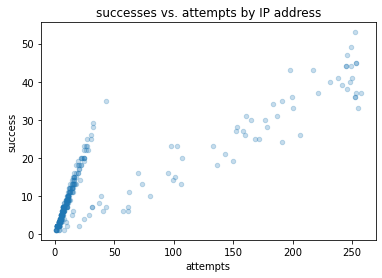

In [24]:
pivot.plot(
    kind='scatter', x='attempts', y='success', 
    title='successes vs. attempts by IP address', alpha=0.25
)

Perhaps we can draw a boundary between these groups:

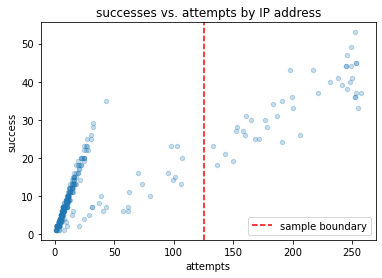

In [25]:
ax = pivot.plot(
    kind='scatter', x='attempts', y='success', 
    title='successes vs. attempts by IP address', alpha=0.25
)
plt.axvline(125, label='sample boundary', color='red', linestyle='--')
plt.legend(loc='lower right')

Since we are in the research phase, we have some labeled data, so we can see if our boundary was correct:

Text(0.5, 0.98, 'successes vs. attempts by IP address')

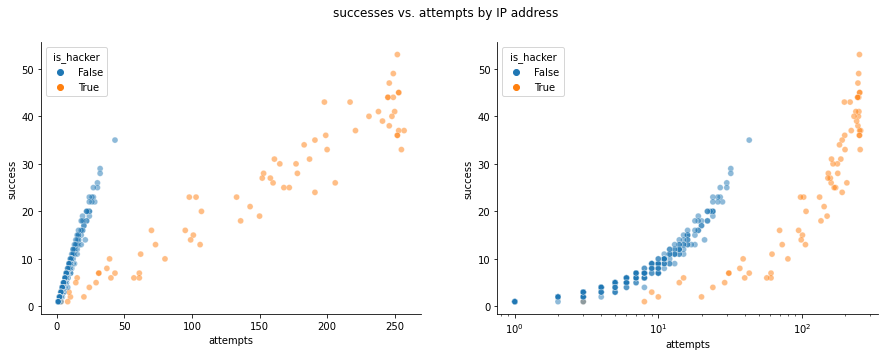

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
for ax in axes:
    sns.scatterplot(
        y=pivot.success, x=pivot.attempts, 
        hue=pivot.assign(
            is_hacker=lambda x: x.index.isin(attacks.source_ip)
        ).is_hacker,
        ax=ax, alpha=0.5
    )
    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)
axes[1].set_xscale('log')
plt.suptitle('successes vs. attempts by IP address')

Can a box plot show us outliers corresponding to the top right cluster in the previous scatter plots?

attempts       AxesSubplot(0.125,0.125;0.352273x0.755)
success     AxesSubplot(0.547727,0.125;0.352273x0.755)
dtype: object

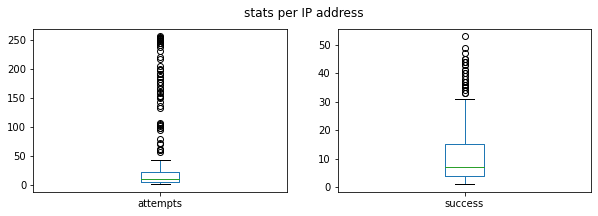

In [27]:
pivot[['attempts', 'success']].plot(
    kind='box', subplots=True, figsize=(10, 3),
    title='stats per IP address'
)

## Rule-based Anomaly Detection
We want to find the IP addresses with excessive amounts of attempts with low success rates and those attempting to log in with more unique usernames than we would deem normal (anomalies).

In [28]:
hourly_ip_logs = log.assign(
    failures=lambda x: np.invert(x.success)
).groupby('source_ip').resample('1H').agg(
    {'username': 'nunique', 'success': 'sum', 'failures': 'sum'}
).assign(
    attempts=lambda x: x.success + x.failures,
    success_rate=lambda x: x.success / x.attempts,
    failure_rate=lambda x: 1 - x.success_rate
).dropna().reset_index()

The data we will use for rule-based anomaly detection looks like this:

In [29]:
hourly_ip_logs.head()

,source_ip,datetime,username,success,failures,attempts,success_rate,failure_rate
0,1.138.149.116,2018-11-01 04:00:00,1,5,1,6,0.833333,0.166667
1,1.138.149.116,2018-11-05 18:00:00,1,1,0,1,1.000000,0.000000
2,1.138.149.116,2018-11-05 19:00:00,1,1,0,1,1.000000,0.000000
3,1.138.149.116,2018-11-06 03:00:00,1,2,0,2,1.000000,0.000000
4,1.138.149.116,2018-11-06 04:00:00,1,2,0,2,1.000000,0.000000


### Percent Difference from Threshold
A simple rule would be to check if values are a certain percentage or more different from some threshold. 

#### Bootstrapping
In our case, the threshold will be an hourly baseline of login activity. We could use bootstrapping to calculate the baseline with random sample of size 10 for each hour:

In [30]:
def get_baselines(hourly_ip_logs, func, *args, **kwargs):
    """
    Calculate hourly bootstrapped statistic per column.
    
    Parameters:
        - hourly_ip_logs: Data to sample from.
        - func: Statistic to calculate.
        - args: Additional positional arguments for `func`
        - kwargs: Additional keyword arguments for `func`
    
    Returns:
        `pandas.DataFrame` of hourly bootstrapped statistics
    """
    if isinstance(func, str):
        func = getattr(pd.DataFrame, func)

    return hourly_ip_logs\
        .assign(hour=lambda x: x.datetime.dt.hour).groupby('hour')\
        .apply(
            lambda x: x.sample(10, random_state=0, replace=True)\
                .pipe(func, *args, **kwargs, numeric_only=True)
        )

When we run our function, we get a bootstrapped hourly average to use as a baseline:

In [31]:
averages = get_baselines(hourly_ip_logs, 'mean')
averages.shape

(24, 7)

This technique however doesn't guarantee we won't mix any of the hacker activity into our baseline calculations:

In [32]:
averages.nlargest(6, 'failure_rate')

,username,success,failures,attempts,success_rate,failure_rate,hour
hour,,,,,,,
19,14.9,5.5,21.4,26.9,0.736876,0.263124,19.0
23,12.4,3.9,18.7,22.6,0.791195,0.208805,23.0
3,1.0,1.1,0.4,1.5,0.800000,0.200000,3.0
11,1.1,2.0,0.6,2.6,0.816667,0.183333,11.0
14,24.7,8.4,35.5,43.9,0.833401,0.166599,14.0
16,1.0,1.5,0.4,1.9,0.841667,0.158333,16.0


#### Trimming
We need to remove some of the outliers for better baselines. Let's write a function to trim values beyond a given quantile:

In [33]:
def trim(x, quantile):
    """Remove rows with entries for the username, attempts, or failure_rate columns above a given quantile."""
    mask = ((x.username <= x.username.quantile(quantile))
        & (x.attempts <= x.attempts.quantile(quantile))
        & (x.failure_rate <= x.failure_rate.quantile(quantile)))
    return x[mask]

This function can be used when we run `apply()` after `groupby()`:

In [34]:
trimmed_hourly_logs = hourly_ip_logs\
    .assign(hour=lambda x: x.datetime.dt.hour)\
    .groupby('hour').apply(lambda x: trim(x, 0.95))\
    .drop(columns='hour').reset_index().iloc[:,2:]

Our trimmed baseline doesn't have really large values anymore:

In [35]:
averages = get_baselines(trimmed_hourly_logs, 'mean')
averages.iloc[[19, 23, 3, 11, 14, 16]]

,username,success,failures,attempts,success_rate,failure_rate,hour
hour,,,,,,,
19,1.0,1.4,0.4,1.8,0.871429,0.128571,19.0
23,1.0,2.0,0.1,2.1,0.966667,0.033333,23.0
3,1.0,2.0,0.3,2.3,0.925000,0.075000,3.0
11,1.1,1.9,0.2,2.1,0.933333,0.066667,11.0
14,1.0,1.4,0.2,1.6,0.950000,0.050000,14.0
16,1.0,1.4,0.2,1.6,0.925000,0.075000,16.0


Next, we need a function to determine when our thresholds are exceeded. Our threshold will be some percentage of the baseline:

In [36]:
def pct_change_threshold(hourly_ip_logs, baselines, pcts=None):
    """
    Return flagged IP addresses based on thresholds.
    
    Parameters:
        - hourly_ip_logs: Aggregated hourly data per IP address.
        - baselines: Hourly baselines per column in data.
        - pcts: Dictionary of custom percentages per column for
                calculating upper bound thresholds (baseline * pct).
                If not provided, pct will be 1.
    
    Returns:
        `pandas.Series` containing the IP addresses flagged.
    """
    pcts = {} if not pcts else pcts

    return hourly_ip_logs.assign(
        hour=lambda x: x.datetime.dt.hour
    ).join(
        baselines, on='hour', rsuffix='_baseline'
    ).assign(
        too_many_users=lambda x: x.username_baseline \
            * pcts.get('username', 1) <= x.username,
        too_many_attempts=lambda x: x.attempts_baseline \
            * pcts.get('attempts', 1) <= x.attempts,
        high_failure_rate=lambda x: x.failure_rate_baseline \
            * pcts.get('failure_rate', 1) <= x.failure_rate
    ).query(
        'too_many_users and too_many_attempts and high_failure_rate'
    ).source_ip.drop_duplicates()

Let's see how many IP addresses get flagged for being 25% greater than the mean baselines for distinct usernames, number of attempts, and failure rate:

In [37]:
pct_from_mean_ips = pct_change_threshold(
    hourly_ip_logs, averages, 
    {key: 1.25 for key in ['username', 'attempts', 'failure_rate']}
)
pct_from_mean_ips.nunique()

73

### Tukey Fence
Another strategy is to use the upper bound of the Tukey fence. The multiplier on the IQR is a parameter we will want to tune:

In [38]:
def tukey_fence_test(trimmed_data, logs, k, pct=None):
    """
    See which IP addresses get flagged with a Tukey fence with
    multiplier k and optional percent differences.
    
    Parameters: 
        - trimmed_data: The data to use to calculate the baselines
        - logs: The data to test
        - k: The multiplier for the IQR
        - pct: Dictionary of percentages per column for use with `pct_change_threshold()`
        
    Returns:
        `pandas.Series` of flagged IP addresses
    """
    q3 = get_baselines(trimmed_data, 'quantile', .75).drop(columns=['hour'])
    q1 = get_baselines(trimmed_data, 'quantile', .25).drop(columns=['hour'])
    iqr = q3 - q1
    upper_bound = (q3 + k * iqr).reset_index()
    return pct_change_threshold(logs, upper_bound, pct)

Let's see what gets flagged using the Tukey fence upper bound using a multiplier of 3 for the IQR:

In [39]:
tukey_fence_ips = tukey_fence_test(
    trimmed_hourly_logs, hourly_ip_logs, k=3
)

We once again use `nunique()` to see the number of items flagged:

In [40]:
tukey_fence_ips.nunique()

83

### Z-score
We can use the Z-score to flag values beyond a certain number of standard deviations above the mean:

In [41]:
def z_score_test(trimmed_data, logs, cutoff):
    """
    See which IP addresses get flagged with a Z-score greater than
    or equal to a cutoff value.
    
    Parameters: 
        - trimmed_data: The data to use to calculate the baselines
        - logs: The data to test
        - cutoff: Flag row when z_score >= cutoff
        
    Returns:
        `pandas.Series` of flagged IP addresses
    """
    std_dev = get_baselines(trimmed_data, 'std').drop(columns=['hour'])
    averages = get_baselines(trimmed_data, 'mean').drop(columns=['hour'])

    return logs.assign(
        hour=lambda x: x.datetime.dt.hour
    ).join(
        std_dev.join(
            averages, 
            lsuffix='_std', 
            rsuffix='_mean'
        ),
        on='hour'
    ).assign(
        too_many_users=lambda x: \
            (x.username - x.username_mean) / x.username_std >= cutoff,
        too_many_attempts=lambda x: \
            (x.attempts - x.attempts_mean) / x.attempts_std >= cutoff,
        high_failure_rate=lambda x: \
            (x.failure_rate - x.failure_rate_mean) / x.failure_rate_std >= cutoff
    ).query(
        'too_many_users and too_many_attempts and high_failure_rate'
    ).source_ip.drop_duplicates()

z_score_ips = z_score_test(trimmed_hourly_logs, hourly_ip_logs, 3)
z_score_ips.nunique()

62

### Evaluating Methods
This is a classification problem with 4 outcomes:

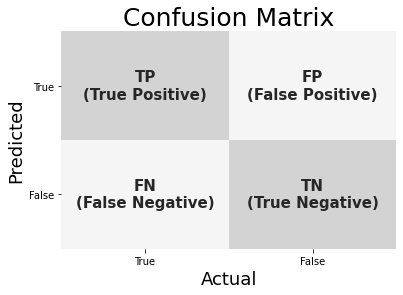

In [42]:
from visual_aids import ml_viz
_ = ml_viz.confusion_matrix()

We can write a function to calculate the metrics of the confusion matrix:

In [43]:
def evaluate(alerted_ips, attack_ips, log_ips):
    """
    Calculate true positives (TP), false positives (FP), 
    true negatives (TN), and false negatives (FN) for 
    IP addresses flagged as suspicious.
    
    Parameters:
        - alerted_ips: `pandas.Series` of flagged IP addresses
        - attack_ips: `pandas.Series` of attacker IP addresses
        - log_ips: `pandas.Series` of all IP addresses seen
    
    Returns:
        Tuple of form (TP, FP, TN, FN)
    """
    tp = alerted_ips.isin(attack_ips).sum()
    tn = np.invert(np.isin(log_ips[~log_ips.isin(alerted_ips)].unique(), attack_ips)).sum()
    fp = np.invert(alerted_ips.isin(attack_ips)).sum()
    fn = np.invert(attack_ips.isin(alerted_ips)).sum()
    return tp, fp, tn, fn

Using, partials we can reduce our typing later by providing the arguments only once:

In [44]:
# make this easier to call
from functools import partial
scores = partial(evaluate, attack_ips=attacks.source_ip, log_ips=pivot.index)

#### Percent Difference from Mean
Let's see how well the percent difference from the mean method did. Using our partial, we get all the components of the confusion matrix:

In [45]:
tp, fp, tn, fn = scores(pct_from_mean_ips)

We can use these to calculate the **false positive rate (FPR)** or the false alarm rate:

$$ FPR = \frac{FP}{FP + TN} $$ 

and the **false discovery rate (FDR)** or the percentage of our alarms that are wrong:

$$ FDR = \frac{FP}{FP + TP} $$ 

In [46]:
# fpr, fdr
fp / (fp + tn), fp / (fp + tp)

(0.00392156862745098, 0.0136986301369863)

To look into false negatives, we can calculate the **false negative rate (FNR)** or the miss rate:

$$ FNR = \frac{FN}{FN + TP} $$

and the **false omission rate (FOR)**:

$$ FOR = \frac{FN}{FN + TN} $$

In [47]:
# fnr, for
fn / (fn + tp), fn / (fn + tn)

(0.0, 0.0)

Let's create a function to calculate all of this for us, so we can compare the methods:

In [48]:
def classification_stats(tp, fp, tn, fn):
    """Calculate metrics"""
    return {
        'FPR': fp / (fp + tn),
        'FDR': fp / (fp + tp),
        'FNR': fn / (fn + tp),
        'FOR': fn / (fn + tn)
    }

Percent difference from the mean using trimmed baselines performs well all around:

In [49]:
classification_stats(tp, fp, tn, fn)

{'FPR': 0.00392156862745098, 'FDR': 0.0136986301369863, 'FNR': 0.0, 'FOR': 0.0}

#### Percent Difference from the Median
We don't need to use the trimmed data here because the median is robust to outliers:

In [50]:
medians = get_baselines(hourly_ip_logs, 'median')
pct_from_median_ips = pct_change_threshold(
    hourly_ip_logs, medians, 
    {key: 1.25 for key in ['username', 'attempts', 'failure_rate']}
)
tp, fp, tn, fn = scores(pct_from_median_ips)
classification_stats(tp, fp, tn, fn)

{'FPR': 0.00784313725490196,
 'FDR': 0.02702702702702703,
 'FNR': 0.0,
 'FOR': 0.0}

#### Comparing Methods
We can use a `DataFrame` object to easily compare the methods we tried. All perform well, which one we use in practice will depend on the cost of false negatives vs. false positives:

In [51]:
pd.DataFrame({
    method: classification_stats(*scores(ips))
    for method, ips in {
        'means': pct_from_mean_ips,
        'medians': pct_from_median_ips,
        'Tukey fence': tukey_fence_ips,
        'Z-scores': z_score_ips
    }.items()
})

,means,medians,Tukey fence,Z-scores
FPR,0.003922,0.007843,0.078431,0.000000
FDR,0.013699,0.027027,0.240964,0.000000
FNR,0.000000,0.000000,0.125000,0.138889
FOR,0.000000,0.000000,0.036885,0.037736


<hr>
<div style="overflow: hidden; margin-bottom: 10px;">
    <div style="float: left;">
         <a href="../ch_07/financial_analysis.ipynb">
            <button>&#8592; Chapter 7</button>
        </a>
    </div>
    <div style="float: right;">
        <a href="../../solutions/ch_08/solutions.ipynb">
            <button>Solutions</button>
        </a>
        <a href="../ch_09/red_wine.ipynb">
            <button>Chapter 9 &#8594;</button>
        </a>
    </div>
</div>
<hr>